In [1]:
import os
os.chdir("/home/robbe/ionbot/")
from statannotations.Annotator import Annotator
import pandas as pd
import numpy as np
import seaborn as sns
import OxiAnalysis as OA
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from pyteomics import mass as pymass
import re

In [2]:
quant = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD016278/flashlfq/QuantifiedPeptides.tsv", sep="\t")
quant.drop(list(quant.filter(regex = 'Detection Type')), axis = 1, inplace = True)
quant = quant[~quant["Protein Groups"].str.contains("sp|", na=False, regex=False)]

quant.head()

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
0,AAAAAAAAAAAAAAAGAGAGAKnan,AAAAAAAAAAAAAAAGAGAGAK,S12A2_HUMAN,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,...,0.000000e+00,6.157306e+05,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,NaN
1,AAAAAAAAAKnan,AAAAAAAAAK,PHX2B_HUMAN,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,NaN
2,AAAAAAAAAVSRR12|[981]glucosone[R],AAAAAAAAAVSRR,NaN,NaN,NaN,3.159841e+06,194429.501953,0.000000e+00,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,NaN
3,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,...,1.407283e+06,1.882486e+06,0.0,0.0,0.0,0.0,0.0,2.078671e+07,0.0,NaN
4,AAAAAAAAGAFAGRR15|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.000000e+00,0.000000,4.562765e+06,8516465.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,NaN


In [3]:
cols = [col for col in quant.columns if "Intensity" in col]

In [4]:
quant = OA.quantile_transform(quant, cols)

In [6]:
summedintensities = OA.summedintensities(quant)

/home/robbe/ionbot/OxiAnalysis.py:444: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantexox.drop(list(quantexox.filter(regex = 'Detection Type')), axis = 1, inplace = True)


In [7]:
Controldf = summedintensities.filter(regex="Modifications|ctrl2")
ADdf = summedintensities.filter(regex="Modifications|AD2")

In [8]:
pvallist = []

In [9]:
def boxplots(Controldf, Treatmentdf, specific=True):
    db = pymass.Unimod()

    pvallist = []
    for index, row in Controldf.iterrows():
        for index2, row2 in Treatmentdf.iterrows():
            if index == index2:
                if specific:
                    mod = row["Modifications"]
                    modname = re.search(pattern=r"\[\d+\](.*)", string=mod).group(1)
                else:
                    modname = "Dioxidation"
                dataControl = Controldf.iloc[index][1:]
                dataControl = dataControl.astype(float)
                dataControl = dataControl.astype(float)
                dataControl = dataControl[dataControl != 0]
                dataTreatment = Treatmentdf.iloc[index][1:]
                dataTreatment = dataTreatment.astype(float)
                dataTreatment = dataTreatment[dataTreatment !=0]
                if dataTreatment.size != 0 and dataControl.size != 0:
                    pval = stats.mannwhitneyu(dataControl, dataTreatment).pvalue
                    pvallist.append(pval)
                    if pval < 0.05:
                        plt.figure(figsize=(8,8))
                        df = pd.DataFrame({"Control subjects": pd.Series(dataControl.values), "AD patients": pd.Series(dataTreatment.values)})
                        
                        ax = sns.boxplot(data=df)
                        pairs = list(combinations(["Control subjects", "AD patients"], r=2))
                        annotator = Annotator(ax, pairs = pairs, data=df)
                        annotator.configure(test="Mann-Whitney", verbose=0, text_format="simple")
                        annotator.apply_and_annotate()
                        sns.stripplot(data=df, alpha = 0.7, color="black")
                        
                        plt.title("{}-modified peptide intensities".format(modname))
                        plt.ylabel("summed log2(peptide intensities)")
                        plt.show()
    corrected_pvals = multipletests(pvallist, method= "fdr_bh")[1].tolist()
    for i in zip(pvallist, corrected_pvals):
        if i[0] < 0.05:
            print("{} => {}".format(i[0], i[1]))
                

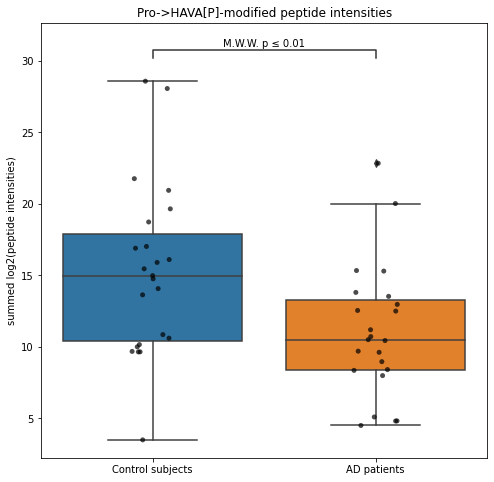

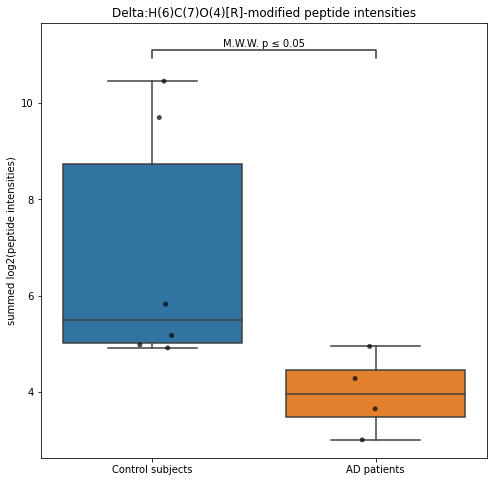

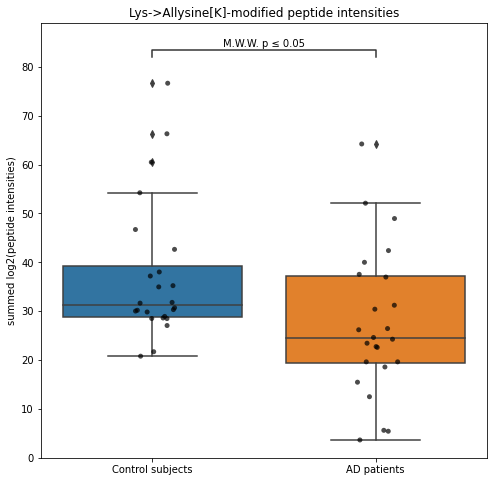

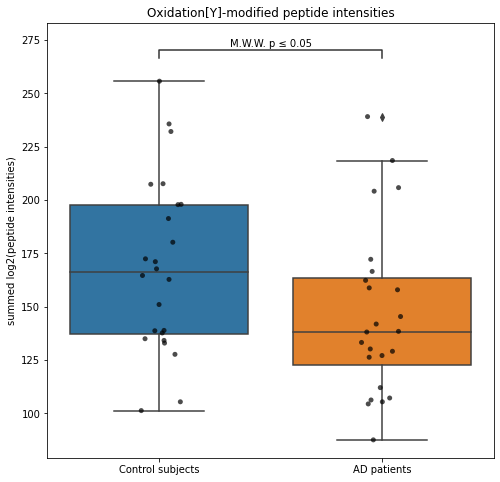

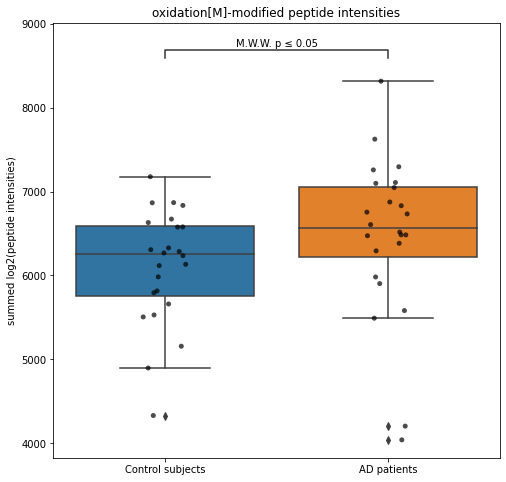

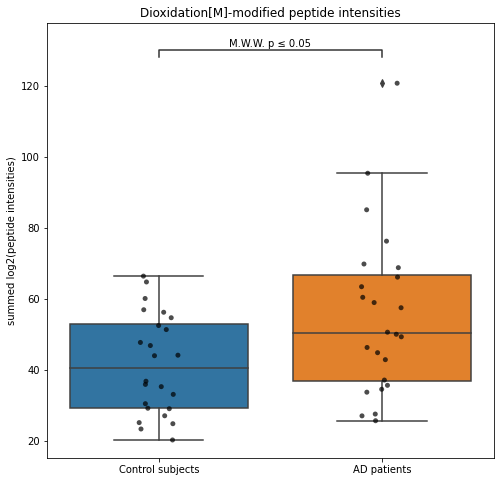

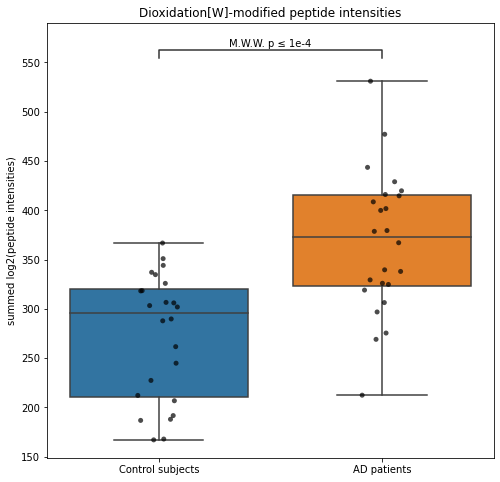

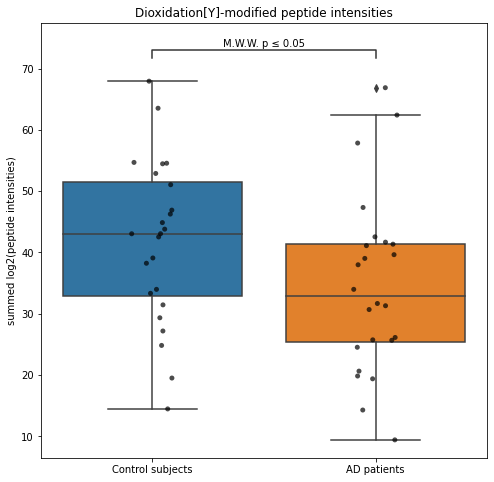

0.008940198874736578 => 0.38889865105104116
0.01904761904761905 => 0.4142857142857143
0.013737753233950132 => 0.3983948437845538
0.048932790787893914 => 0.5321440998183463
0.048932790787893914 => 0.5321440998183463
0.029602150981776827 => 0.5150774270829168
6.6100390565615e-05 => 0.005750733979208505
0.048932790787893914 => 0.5321440998183463


In [10]:
boxplots(Controldf, ADdf)

# Same but non-specific

In [11]:
summedintensities["UnimodAccession"] = summedintensities["Modifications"].apply(OA.get_unimod_acc)

In [12]:
nssi = summedintensities.groupby("UnimodAccession").sum().reset_index()

In [13]:
Controldf = nssi.filter(regex="UnimodAccession|ctrl2")
ADdf = nssi.filter(regex="UnimodAccession|AD2")

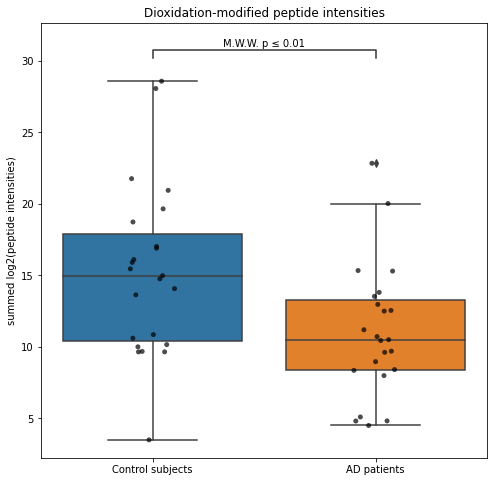

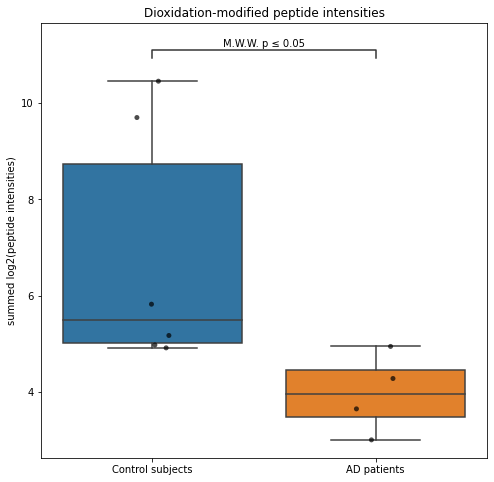

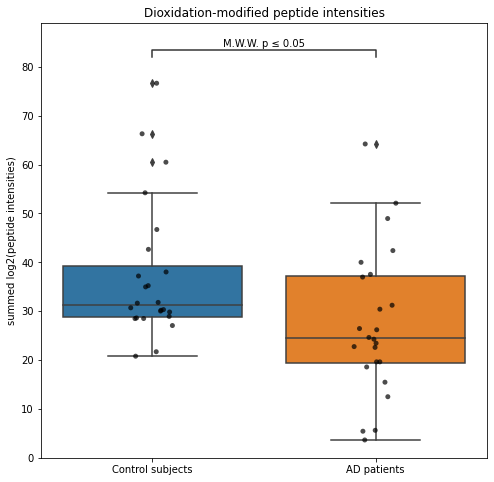

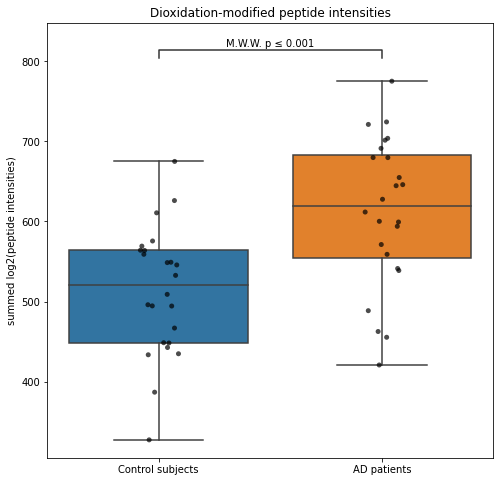

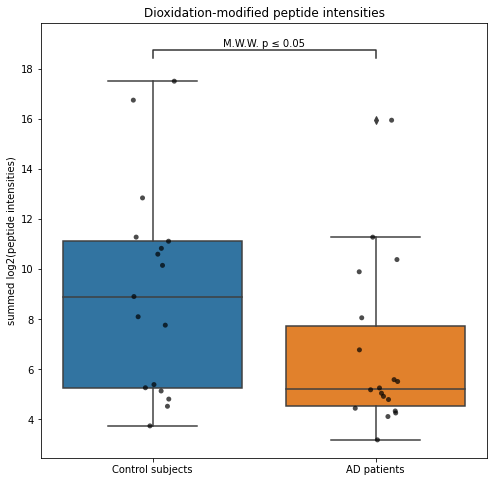

0.008940198874736578 => 0.19221427580683642
0.01904761904761905 => 0.20476190476190478
0.013737753233950132 => 0.19690779635328523
0.0005965632210801782 => 0.025652218506447663
0.04584718038381977 => 0.39428575130085003


In [14]:
boxplots(Controldf=Controldf, Treatmentdf=ADdf, specific=False)

# Corroboration with MSFragger?

In [15]:
quant = pd.read_csv("/home/robbe/ionbot/Fragpipe_results/PXD016278/QuantifiedPeptides.tsv", sep="\t")
quant.drop(list(quant.filter(regex = 'Detection Type')), axis = 1, inplace = True)
quant = quant[~quant["Protein Groups"].str.contains("sp|", na=False, regex=False)]

quant.head()

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
0,AAAAAAAAAAAAAAAGAGAGAK|nan|nan,AAAAAAAAAAAAAAAGAGAGAK,P55011,NaN,NaN,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,6.157306e+05,0.0,0.0,0.0,0.0,0.0,0.00,0.0,NaN
1,AAAAAAALQAK|nan|Mod1: 2-amino-3-oxo-butanoic_a...,AAAAAAALQAK,P36578,NaN,NaN,0.0,0.0,4.783178e+06,2.405819e+06,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,NaN
2,AAAAAAALQAK|nan|nan,AAAAAAALQAK,P36578,NaN,NaN,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,NaN
3,AAAATGTIFTFR|nan|Mod1: Formylation (PeakApex: ...,AAAATGTIFTFR,P05154,NaN,NaN,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,6.230569e+05,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,NaN
4,AAAATGTIFTFR|nan|nan,AAAATGTIFTFR,P05154,NaN,NaN,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,1.943068e+06,1.020630e+08,0.0,0.0,0.0,0.0,0.0,7989761.75,37485756.5,NaN


In [16]:
cols = [col for col in quant.columns if "Intensity" in col]

In [17]:
quant = OA.quantile_transform(quant, cols)

In [18]:
dihydroxy = quant[quant["Sequence"].str.contains(r"dihydroxy(,| )")]

/tmp/ipykernel_640374/3373579793.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  dihydroxy = quant[quant["Sequence"].str.contains(r"dihydroxy(,| )")]


In [19]:
dihydroxy.drop(["Sequence", "Base Sequence", "Protein Groups", "Gene Names", "Organism", "Unnamed: 101"], inplace=True, axis=1)

/tmp/ipykernel_640374/3892281240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dihydroxy.drop(["Sequence", "Base Sequence", "Protein Groups", "Gene Names", "Organism", "Unnamed: 101"], inplace=True, axis=1)


In [20]:
sums = dihydroxy.sum()

In [21]:
ADsums = sums.filter(regex="AD2")
Controlsums = sums.filter(regex="ctrl")

In [22]:
pval = stats.mannwhitneyu(Controlsums, ADsums).pvalue

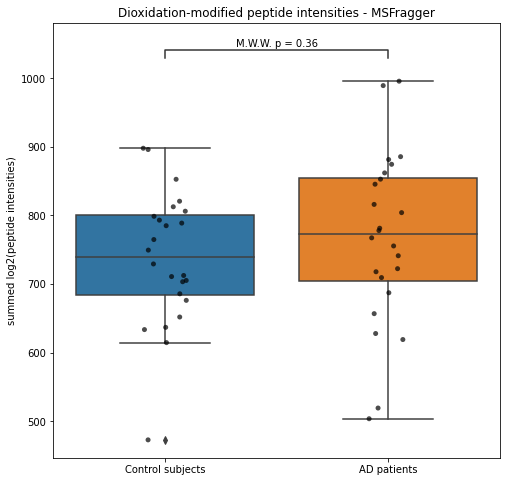

In [23]:
plt.figure(figsize=(8,8))
df = pd.DataFrame({"Control subjects": Controlsums, "AD patients": ADsums})
ax = sns.boxplot(data=df)
pairs = list(combinations(["Control subjects", "AD patients"], r=2))
annotator = Annotator(ax, pairs = pairs, data=df)
annotator.configure(test="Mann-Whitney", verbose=0, text_format="simple")
annotator.apply_and_annotate()
sns.stripplot(data=df, alpha = 0.7, color="black")

plt.title("{}-modified peptide intensities - MSFragger".format("Dioxidation"))
plt.ylabel("summed log2(peptide intensities)")
plt.show()
